<!--
CSI-6-ARI Week 3 Tutorial
Local Search, Hill Climbing, and Genetic Algorithms
-->

<style>
  :root{
    --bg:#0b1320;
    --fg:#eef3fb;
    --muted:#b9c6dc;
    --card:#ffffff;
    --line:#e6eaf2;
    --soft:#f6f8fb;
    --info:#eef6ff;
    --warn:#fff7e6;
    --task:#fff0f3;
    --ok:#eefaf0;
    --infoLine:#cfe5ff;
    --warnLine:#ffe1a6;
    --taskLine:#ffd1dc;
    --okLine:#bfe8c7;
  }

  /* Consistent notebook typography */
  .markdown, .markdown p, .markdown li, .markdown div { font-size: 16px; line-height: 1.65; }
  h1 { font-size: 36px; margin: 0 0 12px 0; }
  h2 { font-size: 24px; margin: 22px 0 10px 0; }
  h3 { font-size: 19px; margin: 16px 0 8px 0; }

  .hero{
    padding:20px 22px;
    border-radius:18px;
    background:var(--bg);
    color:var(--fg);
    border:1px solid rgba(255,255,255,0.12);
  }
  .hero .subtitle{margin-top:10px;font-size:18px;font-weight:650;color:var(--muted);}
  .hero .meta{margin-top:10px;font-size:14px;color:var(--muted);}

  .grid{display:grid;grid-template-columns:1fr 1fr;gap:12px;margin-top:14px;}
  .card{
    padding:14px 16px;
    border-radius:16px;
    background:var(--card);
    border:1px solid var(--line);
    box-shadow:0 1px 0 rgba(20,30,50,0.04);
  }
  .card h3{margin:0 0 10px 0;font-size:18px;}

  .box{padding:14px 16px;border-radius:16px;border:1px solid var(--line);background:var(--soft);margin:12px 0;}
  .box.info{background:var(--info);border-color:var(--infoLine);}
  .box.warn{background:var(--warn);border-color:var(--warnLine);}
  .box.task{background:var(--task);border-color:var(--taskLine);}
  .box.ok{background:var(--ok);border-color:var(--okLine);}

  .boxtitle{font-weight:850;font-size:18px;margin:0 0 8px 0;display:flex;gap:10px;align-items:center;}

  .badge{
    width:28px;height:28px;
    border-radius:9px;
    display:inline-flex;align-items:center;justify-content:center;
    font-weight:900;font-size:16px;
    border:1px solid rgba(0,0,0,0.08);
  }
  .b-info{background:#dbeafe;color:#1d4ed8;}
  .b-warn{background:#ffedd5;color:#c2410c;}
  .b-task{background:#ffe4e6;color:#be123c;}
  .b-ok{background:#dcfce7;color:#166534;}

  code{background:#f1f5f9;border-radius:6px;padding:1px 6px;}
  details{border:1px dashed #cbd5e1;border-radius:14px;padding:10px 12px;background:#fbfdff;}
  summary{cursor:pointer;font-weight:850;font-size:16px;}
</style>

<div class="hero">
  <h1><b>CSI-6-ARI, Week 3 Tutorial</b></h1>
  <div class="subtitle">Local Search, Hill Climbing, and Genetic Algorithms</div>
</div>

<div class="grid">
  <div class="card">
    <h3>🎯 Learning outcomes</h3>
    <ul>
      <li>Explain what <b>local search</b> is, and when it is preferable to full graph search.</li>
      <li>Implement <b>hill climbing</b> (first-improvement and best-improvement), and interpret common failure modes (local maxima, plateaus, ridges).</li>
      <li>Apply <b>random-restart hill climbing</b> to improve robustness on multi-modal landscapes.</li>
      <li>Implement a minimal <b>Genetic Algorithm</b> (selection, crossover, mutation, elitism), and compare it to hill climbing on the same optimisation task.</li>
    </ul>
  </div>
  <div class="card">
    <h3>🧭 How to use this notebook</h3>
    <ul>
      <li>Run cells top-to-bottom. If you restart the runtime, re-run all cells.</li>
      <li>Exercises include a <b>student cell</b> (with TODOs) and a hidden <code>&lt;details&gt;</code> answer.</li>
      <li>Keep results reproducible by using the provided random seed.</li>
    </ul>
  </div>
</div>


In [2]:
# ✅ Setup
# We fix a random seed so that any random examples (if used) behave the same for everyone.

from __future__ import annotations  # Lets us use type hints more cleanly (safe to ignore for now)

from dataclasses import dataclass   # Simple way to define small data containers (used later)
from typing import Callable, List, Tuple  # Type hints for clarity (functions, lists, and pairs)

import numpy as np                  # Numerical computing (arrays, maths, random numbers)
import matplotlib.pyplot as plt     # Plotting (graphs and visualisations)

SEED = 42                           # Constant to make randomness reproducible
rng = np.random.default_rng(SEED)   # Controlled random number generator for this notebook

print("Setup complete, seed =", SEED)  # Quick confirmation that the environment is ready


Setup complete, seed = 42


## 1) <b>✅ Hill climbing Algorithm</b>

<div class="box">
  <div class="boxtitle"><span class="badge b-info">⛰️</span> What hill climbing does</div>
  <ul>
    <li><b>Goal:</b> improve a solution by repeatedly making <b>small local changes</b> (moves) that increase quality.</li>
    <li><b>Inputs:</b> an initial solution <code>s</code>, a neighbourhood function <code>N(s)</code>, and an objective <code>f(s)</code> you want to <b>maximise</b> (or minimise a cost).</li>
    <li><b>Step 1, start:</b> choose an initial state <code>s</code> (randomly or using a sensible heuristic).</li>
    <li><b>Step 2, look locally:</b> generate and evaluate neighbours <code>N(s)</code> (solutions reachable by one move, e.g., swap, shift, flip).</li>
    <li><b>Step 3, move uphill:</b> move to a neighbour <code>s'</code> only if it <b>improves</b> the objective (for maximisation: <code>f(s') &gt; f(s)</code>).</li>
    <li><b>Stop condition:</b> stop when <b>no neighbour improves</b> the objective. The current solution is a <b>local optimum</b> with respect to that neighbourhood.</li>
    <li><b>Practical note:</b> hill climbing is <b>memory-light</b> (stores only the current solution), so it scales well to very large search spaces.</li>
  </ul>
</div>

<div class="box info">
  <div class="boxtitle"><span class="badge b-info">🧩</span> Neighbourhood design matters</div>
  <ul>
    <li><b>The neighbourhood defines what “local” means.</b> If your moves are too small, you may get stuck easily. If moves are too large, each step becomes expensive to evaluate.</li>
    <li><b>Examples of neighbour moves:</b></li>
    <ul>
      <li><b>Swap:</b> exchange two items (two lectures, two tasks, two cities in a route).</li>
      <li><b>Shift:</b> move one item to a different position/time slot.</li>
      <li><b>Flip:</b> change a binary choice (0→1 or 1→0).</li>
      <li><b>Reassign:</b> move one job from one machine/robot to another.</li>
    </ul>
    <li><b>Neighbour evaluation cost:</b> if <code>|N(s)|</code> is huge, you may sample neighbours instead of evaluating all of them.</li>
  </ul>
</div>

<div class="box info">
  <div class="boxtitle"><span class="badge b-info">🔀</span> Common hill-climbing variants (tie-breaking rules)</div>
  <ul>
    <li><b>Steepest-ascent:</b> evaluate (many/all) neighbours and choose the best improving neighbour. More expensive per step, often fewer steps.</li>
    <li><b>First-choice:</b> check neighbours in some order and take the first improving one. Cheaper per step, but may be less stable.</li>
    <li><b>Stochastic:</b> pick an improving neighbour at random (sometimes weighted by improvement). Useful when many neighbours look similar.</li>
    <li><b>Sideways moves (optional):</b> allow a limited number of equal-score moves (<code>f(s') = f(s)</code>) to escape plateaus.</li>
  </ul>
</div>

<div class="box warn">
  <div class="boxtitle"><span class="badge b-warn">⚠️</span> Common failure modes (why it stops “too early”)</div>
  <ul>
    <li><b>Local maxima (local optimum):</b> every neighbour is worse, so the algorithm stops, even though a better solution exists elsewhere in the space.</li>
    <li><b>Plateaus:</b> many neighbours have the <b>same</b> score, so the algorithm may stop immediately or waste steps wandering without improving.</li>
    <li><b>Ridges:</b> improvement exists, but not via a single obvious uphill move. You may need a sequence of moves that temporarily look unhelpful (or sideways) to reach a better region.</li>
    <li><b>Neighbourhood mismatch:</b> the move set is too restrictive, so the algorithm cannot reach better solutions without “breaking” the current structure.</li>
  </ul>
</div>

<div class="box ok">
  <div class="boxtitle"><span class="badge b-ok">✅</span> Simple, effective fixes</div>
  <ul>
    <li><b>Random-restart hill climbing:</b> run hill climbing multiple times from different random initial states, keep the best final solution.</li>
    <li><b>Why it works:</b> each run may get trapped in a different local optimum, so multiple restarts increase the chance of finding a much better region.</li>
    <li><b>In practice:</b> you set a budget (e.g., number of restarts or total evaluations) and track the best-so-far objective value.</li>
  </ul>
</div>


<div  <div class="boxtitle"><span class="badge b-info">🧪</span> <b>Worked example 1, maximising a bumpy 1D landscape </b></div>
We will optimise a 1D function over integer inputs, <code>x ∈ [-50, 50]</code>. This is deliberately simple, but it captures the same logic used in many real optimisation problems.</div>

You can think of <code>x</code> as a single decision variable, for example:
<ul>
  <li>choosing one hyperparameter value (e.g., a regularisation strength),</li>
  <li>picking a decision threshold for a classifier,</li>
  <li>selecting an operating point for a machine (speed, temperature, feed rate),</li>
  <li>setting a policy parameter in a control rule.</li>
</ul>

<div class="box info">
  <div class="boxtitle"><span class="badge b-info">🧪</span> Objective</div>
  <ul>
    <li><b>Goal:</b> find the integer <code>x</code> that <b>maximises</b> <code>f(x)</code>.</li>
    <li><b>Search space:</b> only 101 possible values (<code>-50</code> to <code>50</code>), so we can visualise the whole landscape.</li>
    <li><b>Why “bumpy” matters:</b> if <code>f(x)</code> has multiple peaks, a greedy method like hill climbing can stop at a <b>local maximum</b> rather than the global best.</li>
    <li><b>Neighbourhood:</b> from a current point <code>x</code>, the only allowed moves are:</li>
    <ul>
      <li><code>x - 1</code> (one step left),</li>
      <li><code>x + 1</code> (one step right),</li>
    </ul>
    <li><b>Boundary rule:</b> if <code>x = -50</code>, the left neighbour does not exist, if <code>x = 50</code>, the right neighbour does not exist.</li>
    <li><b>Hill-climbing step:</b> evaluate the valid neighbours and move to the one with higher <code>f(x)</code> (or stop if neither improves).</li>
  </ul>
</div>



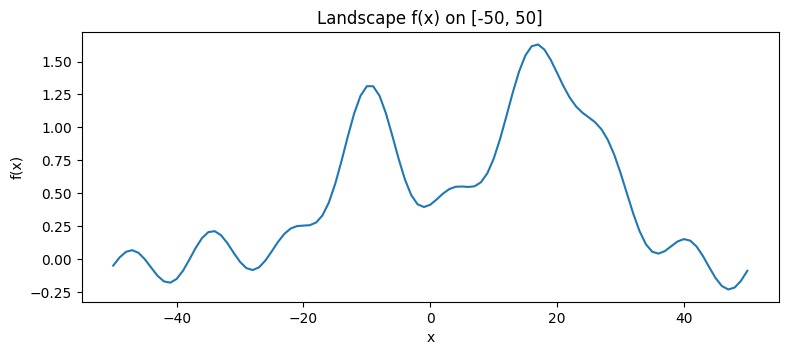

In [3]:
# Define a bumpy landscape (multi-modal) and plot it
# "Multi-modal" means the function has multiple peaks (local maxima),
# which is exactly where hill climbing can get stuck.

def f(x: int) -> float:
    # f(x) is built by combining a few simple patterns:
    # - Two Gaussian "humps" (smooth peaks) centred at x=18 and x=-10
    # - Small sinusoidal ripples (sin/cos) to add extra bumps and plateaus
    #
    # This creates several local maxima, not just one global peak.
    return (
        1.6 * np.exp(-((x - 18) ** 2) / 120)   # Main peak near x = 18 (wider, higher)
        + 1.2 * np.exp(-((x + 10) ** 2) / 60)  # Secondary peak near x = -10 (narrower)
        + 0.15 * np.sin(x / 2)                 # Small oscillations (adds local bumps)
        + 0.08 * np.cos(x / 5)                 # Even smaller oscillations (fine detail)
    )

# Create the integer search space x ∈ {-50, -49, ..., 50}
X = np.arange(-50, 51)

# Evaluate the objective at every x (so we can plot the entire landscape)
Y = np.array([f(int(x)) for x in X])

# Plot the landscape so we can see the peaks and valleys visually
plt.figure(figsize=(9, 3.5))     # Wider figure makes the 1D shape easier to read
plt.plot(X, Y)                   # Draw f(x) for all x in the range
plt.title("Landscape f(x) on [-50, 50]")
plt.xlabel("x")                  # Decision variable
plt.ylabel("f(x)")               # Objective value (what hill climbing tries to maximise)
plt.show()


Start x = 28 | f(x) = 0.906
Final x = 17 | f(x) = 1.6292 | steps = 11


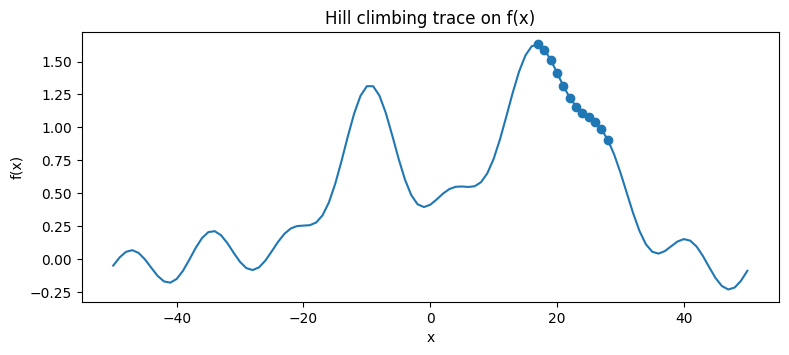

In [5]:
# Hill climbing for the 1D landscape
# We will implement steepest-ascent (best-improvement) hill climbing:
# at each step, evaluate all neighbours and move to the one with the highest objective value.

def neighbours_1d(x: int, lo: int = -50, hi: int = 50) -> List[int]:
    # Neighbourhood definition for 1D integer search:
    # from x, you can move one step left (x-1) or one step right (x+1),
    # as long as you stay within the bounds [lo, hi].
    nbs = []
    if x - 1 >= lo:              # Left move is valid
        nbs.append(x - 1)
    if x + 1 <= hi:              # Right move is valid
        nbs.append(x + 1)
    return nbs


def hill_climb_best_improvement(
    start: int,
    objective: Callable[[int], float],
    neighbours: Callable[[int], List[int]],
    max_steps: int = 1000,
) -> Tuple[int, float, List[int]]:
    """Best-improvement hill climbing (steepest ascent).

    At each iteration:
      1) generate neighbours of the current state,
      2) evaluate them using the objective function,
      3) move to the best neighbour if (and only if) it improves the score.

    Returns:
      (final_state, final_score, trace)
      - final_state: where we stopped (a local maximum w.r.t. the neighbourhood)
      - final_score: objective value at that state
      - trace: the sequence of visited states (useful for plotting the path)
    """
    current = start
    current_score = objective(current)
    trace = [current]            # Keep the full path so we can visualise the search

    for _ in range(max_steps):
        cand = neighbours(current)               # Candidate next states (1-step moves)
        scores = [objective(s) for s in cand]    # Evaluate objective for each candidate

        # Pick the neighbour with the highest score (steepest ascent)
        best_i = int(np.argmax(scores))
        best_state = cand[best_i]
        best_score = scores[best_i]

        # Stopping rule:
        # if the best neighbour is not strictly better, we are at a local maximum.
        if best_score <= current_score:
            break

        # Otherwise move "uphill" and continue
        current, current_score = best_state, best_score
        trace.append(current)

    return current, float(current_score), trace

# Choose a random starting point so different runs can end at different local maxima.
# We use rng (seeded earlier) so the run is reproducible for everyone.
start = int(rng.integers(-50, 51))

# Run hill climbing on our landscape f(x)
best_x, best_fx, trace = hill_climb_best_improvement(start, f, neighbours_1d)

# Report the start and the final solution
print("Start x =", start, "| f(x) =", round(f(start), 4))
print("Final x =", best_x, "| f(x) =", round(best_fx, 4), "| steps =", len(trace) - 1)

# Visualise the hill-climbing path on top of the landscape:
# the dots show the visited x values in the order they were chosen.
plt.figure(figsize=(9, 3.5))
plt.plot(X, Y)                                  # The full landscape
plt.scatter(trace, [f(t) for t in trace])       # The hill-climbing trace (visited points)
plt.title("Hill climbing trace on f(x)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()


<b>=============================  EXERCISE  =============================</b>


<div class="box task">
<div class="boxtitle"><span class="badge b-task">✍️</span> <b>Exercise 1, Hill climbing on a 1D landscape (plot + local/global optima + random restarts)</b></div>

<p><b>Goal:</b> plot a <b>bumpy</b> 1D objective, identify <b>local</b> vs <b>global</b> maxima/minima, then compare a <b>single</b> hill-climb run against <b>random-restart</b> hill climbing.</p>

<ol>
<li>
<b>Define the objective</b> <code>f(x)</code> (copy exactly) where <code>x ∈ {-50, ..., 50}</code>.
<br>
You are <b>maximising</b> <code>f(x)</code> and the neighbourhood is <code>{x-1, x+1}</code>.
</li>

<li>
<b>Plot the landscape</b> for every integer <code>x</code> in <code>[-50, 50]</code>.
<br>
Label axes, and make the plot wide enough to clearly see the bumps.
</li>

<li>
<b>From the plot only (no hill climbing yet), identify optima.</b>
<ul>
<li>Mark your best guess of the <b>global maximum</b> (highest point) and record the approximate <code>x</code>.</li>
<li>Find at least <b>two local maxima</b> (peaks that are higher than their immediate neighbours).</li>
<li>Find at least <b>two local minima</b> (valleys that are lower than their immediate neighbours).</li>
</ul>
<b>Important:</b> with neighbourhood <code>{x-1, x+1}</code>, “local” means only the immediate left and right values matter.
</li>

<li>
<b>Run a normal (single-start) hill climb</b> from one random start.
<ul>
<li>Use steepest-ascent, at each step evaluate both neighbours and move to the best one if it improves the score.</li>
<li>Report: start <code>x</code>, start <code>f(x)</code>, final <code>x</code>, final <code>f(x)</code>, number of steps.</li>
<li>Plot the hill-climb <b>trace</b> on top of the landscape (scatter the visited points).</li>
</ul>
</li>

<li>
<b>Implement random-restart hill climbing</b>.
<br>
Complete <code>random_restart_hill_climb(k)</code> so that it:
<ul>
<li>chooses <code>k</code> random start points in <code>[-50, 50]</code>,</li>
<li>runs hill climbing from each start,</li>
<li>returns the best solution found across all restarts (best <code>x</code> and best <code>f(x)</code>).</li>
</ul>
</li>

<li>
<b>Repeat random-restart 5 times (observe stability).</b>
<ul>
<li>Run <code>random_restart_hill_climb(k=20)</code> five separate times.</li>
<li>Record the best <code>x</code> and best <code>f(x)</code> each time.</li>
<li>Do you consistently find the same best peak, or do results vary?</li>
</ul>
</li>

<li>
<b>Final comparison (single vs restarts).</b>
<ul>
<li>Run a single hill climb once and record its final <code>f(x)</code>.</li>
<li>Run random-restart hill climbing with <code>k=20</code> and record its best <code>f(x)</code>.</li>
</ul>
In 2–4 sentences, explain whether random restarts helped you reach the <b>global maximum</b> you identified from the plot, and why.
</li>
</ol>
</div>

<div style="padding:12px 14px;border-radius:12px;background:#ffffff;border:1px solid var(--line);
font-family:ui-monospace, SFMono-Regular, Menlo, Monaco, Consolas, 'Liberation Mono','Courier New', monospace;
font-size:15px;line-height:1.5;">
<pre style="margin:0;">
1D objective (maximise f(x)), integer domain x ∈ [-50, 50]

f(x) = 1.4 * exp(-((x - 22)^2) / 90)
     + 1.1 * exp(-((x + 15)^2) / 70)
     + 0.9 * exp(-((x - 5)^2) / 25)
     + 0.12 * sin(x / 3)
     - 0.07 * cos(x / 6)

Neighbourhood: N(x) = {x-1, x+1} (within bounds)
Stopping rule: stop when no neighbour strictly improves f(x)
</pre>
</div>

<div class="box ok">
<div class="boxtitle"><span class="badge b-ok">✅</span> What we expect to see</div>
<ul>
<li><b>Single-start hill climbing</b> may stop at different local maxima depending on the starting point.</li>
<li><b>Random restarts</b> sample multiple starting points, so the chance of reaching the <b>highest peak</b> increases.</li>
<li>If <code>k</code> is large enough, random restarts often find the global maximum for this small 1D problem.</li>
</ul>
</div>


In [ ]:
# TODO: Exercise 1 solution area (Hill climbing on a 1D landscape)

# 1) By hand (from the plot only):
# - Mark your estimated GLOBAL maximum:
#   x_global_max ≈
#   f(x_global_max) ≈
#
# - Mark at least TWO LOCAL maxima (peaks higher than immediate neighbours):
#   local_max_1: x ≈ , f(x) ≈
#   local_max_2: x ≈ , f(x) ≈
#
# - Mark at least TWO LOCAL minima (valleys lower than immediate neighbours):
#   local_min_1: x ≈ , f(x) ≈
#   local_min_2: x ≈ , f(x) ≈

# 2) Single-start hill climb (normal hill climbing):
# - Start x =
# - Start f(x) =
# - Final x =
# - Final f(x) =
# - Steps =

# 3) Implement random-restart hill climbing:
# Complete the function below so it runs hill climbing from k random starts
# and returns the best (x, f(x)) found across all restarts.

def random_restart_hill_climb(
    k: int,
    objective: Callable[[int], float],
    neighbours: Callable[[int], List[int]],
    hill_climb_fn: Callable[[int, Callable[[int], float], Callable[[int], List[int]]], Tuple[int, float, List[int]]],
    lo: int = -50,
    hi: int = 50,
) -> Tuple[int, float]:
    # TODO: track the best x and best score across k independent hill-climb runs
    # Hints:
    # - Use rng.integers(lo, hi + 1) for each random start
    # - Call hill_climb_fn(start, objective, neighbours)
    # - Compare the returned best_score, keep the best
    pass

# 4) Run random-restart 5 times (stability check):
# Run random_restart_hill_climb(k=20, ...) five times and record the best results.
#
# Run 1: best x = , best f(x) =
# Run 2: best x = , best f(x) =
# Run 3: best x = , best f(x) =
# Run 4: best x = , best f(x) =
# Run 5: best x = , best f(x) =

# 5) Final comparison (single vs restarts):
# - Best f(x) from ONE single-start hill climb =
# - Best f(x) from random-restart with k=20 =
#
# Write 2–4 sentences:
# Did random restarts help you reach the global maximum you identified from the plot? Why/why not?
# TODO


<details>
  <summary><b>✅ Show solution (one possible full answer)</b></summary>

<p>
<b>Note:</b> Your exact numbers may differ slightly depending on your random starts, but the overall pattern should be the same,
single-start hill climbing can stop at a local maximum, and random restarts increase the chance of finding the best peak.
</p>

```python
# ✅ Full solution: random-restart hill climbing on a 1D landscape

from typing import Callable, List, Tuple

# --- Objective (given in the exercise) ---
def f(x: int) -> float:
    return (
        1.4 * np.exp(-((x - 22) ** 2) / 90)
        + 1.1 * np.exp(-((x + 15) ** 2) / 70)
        + 0.9 * np.exp(-((x - 5) ** 2) / 25)
        + 0.12 * np.sin(x / 3)
        - 0.07 * np.cos(x / 6)
    )

# --- Neighbourhood (given in the exercise) ---
def neighbours_1d(x: int, lo: int = -50, hi: int = 50) -> List[int]:
    nbs = []
    if x - 1 >= lo:
        nbs.append(x - 1)
    if x + 1 <= hi:
        nbs.append(x + 1)
    return nbs

# --- Steepest-ascent hill climbing (best improvement) ---
def hill_climb_best_improvement(
    start: int,
    objective: Callable[[int], float],
    neighbours: Callable[[int], List[int]],
    max_steps: int = 1000,
) -> Tuple[int, float, List[int]]:

    current = start
    current_score = objective(current)
    trace = [current]

    for _ in range(max_steps):
        cand = neighbours(current)
        scores = [objective(s) for s in cand]

        best_i = int(np.argmax(scores))
        best_state = cand[best_i]
        best_score = scores[best_i]

        if best_score <= current_score:
            break

        current, current_score = best_state, best_score
        trace.append(current)

    return current, float(current_score), trace

# --- ✅ Random-restart hill climbing ---
def random_restart_hill_climb(
    k: int,
    objective: Callable[[int], float],
    neighbours: Callable[[int], List[int]],
    lo: int = -50,
    hi: int = 50,
    max_steps: int = 1000,
) -> Tuple[int, float, int]:
    """
    Run hill climbing from k random starts and return the best solution found.

    Returns (best_x, best_fx, best_start):
      - best_x: best final state across restarts
      - best_fx: objective value at best_x
      - best_start: the start x that produced best_x (useful for debugging)
    """
    best_x = None
    best_fx = -float("inf")
    best_start = None

    for _ in range(k):
        start = int(rng.integers(lo, hi + 1))
        x_final, fx_final, _trace = hill_climb_best_improvement(
            start, objective, neighbours, max_steps=max_steps
        )

        if fx_final > best_fx:
            best_x, best_fx, best_start = x_final, fx_final, start

    return int(best_x), float(best_fx), int(best_start)

# --- Plot the landscape ---
X = np.arange(-50, 51)
Y = np.array([f(int(x)) for x in X])

plt.figure(figsize=(9, 3.5))
plt.plot(X, Y)
plt.title("Landscape f(x) on [-50, 50]")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

# --- Single-start hill climb (one run) ---
start = int(rng.integers(-50, 51))
best_x_single, best_fx_single, trace_single = hill_climb_best_improvement(start, f, neighbours_1d)

print("Single-start hill climb")
print("Start x =", start, "| f(x) =", round(f(start), 4))
print("Final x =", best_x_single, "| f(x) =", round(best_fx_single, 4), "| steps =", len(trace_single) - 1)

plt.figure(figsize=(9, 3.5))
plt.plot(X, Y)
plt.scatter(trace_single, [f(t) for t in trace_single])
plt.title("Single-start hill climbing trace")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

# --- Random-restart hill climbing: repeat 5 times with k=20 ---
print("\nRandom-restart hill climbing (k=20), repeated 5 times")
restart_results = []

for i in range(1, 6):
    best_x_rr, best_fx_rr, best_start_rr = random_restart_hill_climb(
        k=20, objective=f, neighbours=neighbours_1d
    )
    restart_results.append((best_x_rr, best_fx_rr, best_start_rr))
    print(f"Run {i}: best x = {best_x_rr}, best f(x) = {best_fx_rr:.4f}, (came from start x = {best_start_rr})")

# --- Final comparison summary ---
best_fx_rr_overall = max(r[1] for r in restart_results)

print("\nComparison")
print("Best f(x) from ONE single-start hill climb =", round(best_fx_single, 4))
print("Best f(x) from random-restart (k=20), best over 5 repeats =", round(best_fx_rr_overall, 4))

# --- Optional: show one restart trace for visual comparison (best run among the 5 repeats) ---
best_run_idx = int(np.argmax([r[1] for r in restart_results]))
best_x_rr, best_fx_rr, best_start_rr = restart_results[best_run_idx]

# Re-run hill climbing from the best_start_rr to retrieve its trace for plotting
best_x_rr2, best_fx_rr2, trace_rr = hill_climb_best_improvement(best_start_rr, f, neighbours_1d)

plt.figure(figsize=(9, 3.5))
plt.plot(X, Y)
plt.scatter(trace_rr, [f(t) for t in trace_rr])
plt.title("Random-restart trace (best run among the 5 repeats)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()


<b>===================================================================</b>


## 2) <b>✅ Use case, 0/1 knapsack (selection under a constraint)</b>

<p>
You have a fixed <b>capacity</b> (a weight, time, energy, or space budget). Each item has a <b>value</b>.
You must decide which items to take (1) or leave (0) to <b>maximise total value</b> while staying within the capacity.
This is called the <b>0/1 knapsack</b> problem because each item can be chosen at most once.
</p>

<div class="box info">
  <div class="boxtitle"><span class="badge b-info">🧩</span> Problem statement (what we are optimising)</div>
  <ul>
    <li><b>Decision variables:</b> for each item <code>i</code>, choose <code>x_i ∈ {0, 1}</code> (0 = not selected, 1 = selected).</li>
    <li><b>Total value:</b> maximise <code>V = Σ v_i x_i</code>.</li>
    <li><b>Total weight:</b> keep <code>W = Σ w_i x_i</code> within capacity <code>C</code> (i.e., <code>W ≤ C</code>).</li>
    <li><b>Trade-off:</b> high-value items are tempting, but you can only fit so much weight, so you must choose a <b>good combination</b>.</li>
  </ul>
</div>

<div class="box warn">
  <div class="boxtitle"><span class="badge b-warn">⚙️</span> Why we need local search (and why greedy can fail)</div>
  <ul>
    <li>The number of possible subsets is <b>2<sup>n</sup></b>. Even for <code>n=50</code>, that is astronomically large.</li>
    <li>A greedy rule like “pick best value/weight ratio first” can miss the best combination because the optimum often depends on <b>how items fit together</b>.</li>
    <li>Local search treats each solution as a <b>binary string</b> (e.g., <code>[1,0,1,0,...]</code>) and improves it by flipping bits (adding/removing items).</li>
  </ul>
</div>

<div class="box ok">
  <div class="boxtitle"><span class="badge b-ok">✅</span> Handling the constraint with a penalty (what we will do)</div>
  <ul>
    <li><b>Key idea:</b> hill climbing needs a single number to optimise, so we turn “value with a constraint” into a single <b>penalised score</b>.</li>
    <li><b>We allow overweight solutions</b> temporarily (they are still “valid states” in the search), but we give them a <b>large penalty</b>.</li>
    <li><b>Penalised objective (maximise):</b></li>
  </ul>

  <div style="padding:10px 12px;border-radius:12px;background:#ffffff;border:1px solid var(--line);
  font-family:ui-monospace, SFMono-Regular, Menlo, Monaco, Consolas, 'Liberation Mono','Courier New', monospace;
  font-size:15px;line-height:1.5;">
  <pre style="margin:0;">
score(x) = total_value(x) - λ * max(0, total_weight(x) - C)

where:
  total_value(x)  = Σ v_i x_i
  total_weight(x) = Σ w_i x_i
  C               = capacity
  λ               = penalty strength (a big number)
  </pre>
  </div>

  <ul>
    <li><b>Interpretation:</b> if you exceed capacity by 1 unit, you lose <code>λ</code> points, so overweight solutions become unattractive.</li>
    <li><b>Why this helps:</b> the search can explore freely, but will naturally move back toward feasible solutions because overweight states score poorly.</li>
  </ul>
</div>

<div class="box info">
  <div class="boxtitle"><span class="badge b-info">🔍</span> Neighbour moves for knapsack (what “local” means here)</div>
  <ul>
    <li><b>Bit-flip move:</b> pick one index <code>i</code> and flip <code>x_i</code> (0→1 adds an item, 1→0 removes an item).</li>
    <li><b>Swap move (optional):</b> remove one item and add another in one step (useful for escaping local optima).</li>
    <li><b>What hill climbing will do:</b> try small changes that increase the penalised score, until no single flip improves it.</li>
  </ul>
</div>



In [8]:
# Knapsack instance
# We define a small 0/1 knapsack problem:
# - Each item can be either selected (1) or not selected (0), you cannot take fractions.
# - Each item has a weight (cost) and a value (benefit).
# - The goal is to maximise total value while keeping total weight ≤ CAPACITY.

@dataclass(frozen=True)
class Item:
    # A simple immutable data structure for one item in the knapsack
    name: str          # Identifier (A, B, C, ...)
    weight: int        # How much capacity this item consumes
    value: int         # How much benefit this item provides

# A toy dataset with different trade-offs:
# some items are light but low value, others are heavy but high value.
# The optimiser must find a good combination that fits within the capacity.
items = [
    Item("A", 4, 12),  # Medium weight, good value
    Item("B", 2, 6),   # Light, decent value
    Item("C", 2, 7),   # Light, slightly better than B
    Item("D", 6, 18),  # Heavy, high value
    Item("E", 5, 14),  # Medium-heavy, good value
    Item("F", 3, 8),   # Medium, moderate value
    Item("G", 7, 20),  # Very heavy, very high value (tempting but expensive)
    Item("H", 1, 3),   # Very light, low value (useful for filling small gaps)
    Item("I", 4, 10),  # Medium weight, moderate value
    Item("J", 3, 9),   # Medium, good value
    Item("K", 5, 13),  # Medium-heavy, moderate value
    Item("L", 2, 5),   # Light, modest value
]

CAPACITY = 15  # Maximum total weight allowed in the knapsack

print("Items:", len(items), "| capacity:", CAPACITY)  # Quick sanity check

Items: 12 | capacity: 15


In [9]:
# Objective and helpers
# We represent a knapsack solution as a 0/1 "bitstring" of length n_items:
# - bitstring[i] = 1 means we TAKE item i
# - bitstring[i] = 0 means we DO NOT take item i
#
# Hill climbing (or any local search) needs:
# 1) a way to evaluate a solution (objective / score)
# 2) a way to generate neighbouring solutions (small local moves)

def unpack(bitstring: np.ndarray) -> Tuple[int, int, List[str]]:
    """Return (total_weight, total_value, item_names).

    This converts the bitstring into interpretable quantities:
    - total_weight: how much capacity we used
    - total_value: how much value we gained
    - item_names: which items were selected
    """
    w = 0
    v = 0
    names = []
    for take, it in zip(bitstring, items):
        if int(take) == 1:       # Item selected
            w += it.weight
            v += it.value
            names.append(it.name)
    return w, v, names


def knapsack_score(bitstring: np.ndarray, penalty: float = 50.0) -> float:
    """Higher is better. Overweight solutions are penalised.

    We use a penalty approach so the optimiser always has a single number to maximise.

    - If the solution is feasible (weight <= CAPACITY), score = total_value.
    - If the solution is overweight, we subtract a large penalty proportional to the excess:
        score = total_value - penalty * (excess_weight)

    The penalty needs to be "big enough" so that going overweight is usually not worth it.
    """
    w, v, _ = unpack(bitstring)
    if w <= CAPACITY:
        return float(v)          # Feasible: pure value
    return float(v - penalty * (w - CAPACITY))  # Overweight: value minus penalty


def neighbours_flip_one(bitstring: np.ndarray) -> List[np.ndarray]:
    """All neighbours by flipping a single bit.

    A single-bit flip is the simplest local move for 0/1 knapsack:
    - 0 -> 1 means "add this item"
    - 1 -> 0 means "remove this item"

    This produces exactly n neighbours for a problem with n items.
    """
    nbs = []
    for i in range(len(bitstring)):
        nb = bitstring.copy()    # Copy so we do not modify the original solution
        nb[i] = 1 - nb[i]        # Flip the i-th decision bit (0<->1)
        nbs.append(nb)
    return nbs


In [10]:
# Hill climbing on bitstrings (best improvement)
# We apply the same hill-climbing idea as in the 1D example, but now:
# - a state is a 0/1 bitstring (one bit per item)
# - a neighbour is produced by flipping one bit (add/remove exactly one item)
# - the score is knapsack_score(bitstring), which includes a penalty if overweight

def hill_climb_bitstring(
    start: np.ndarray,
    score_fn: Callable[[np.ndarray], float],
    neighbours_fn: Callable[[np.ndarray], List[np.ndarray]],
    max_steps: int = 200,
) -> Tuple[np.ndarray, float]:
    """
    Steepest-ascent hill climbing for bitstrings.

    At each step:
      1) generate all neighbours of the current bitstring
      2) evaluate their scores
      3) move to the best neighbour if it strictly improves the score
      4) stop when no neighbour improves (local optimum w.r.t. 1-bit flips)

    Returns:
      (best_bitstring_found, best_score)
    """
    current = start.copy()                 # Work on a copy so we do not modify the original start
    current_score = score_fn(current)      # Score of the current solution

    for _ in range(max_steps):
        cand = neighbours_fn(current)      # All 1-bit-flip neighbours
        scores = [score_fn(s) for s in cand]  # Score each neighbour

        # Choose the neighbour with the highest score (best improvement)
        best_i = int(np.argmax(scores))
        best_state = cand[best_i]
        best_score = scores[best_i]

        # Stop if there is no strictly better move (we are at a local optimum)
        if best_score <= current_score:
            break

        # Otherwise move to the best neighbour and continue searching
        current, current_score = best_state, best_score

    return current, float(current_score)

# Random initial solution: each bit is 0 or 1 with equal probability.
# Because rng is seeded, results are reproducible for everyone.
start = rng.integers(0, 2, size=len(items))

# Run hill climbing on the knapsack problem
sol, sol_score = hill_climb_bitstring(start, knapsack_score, neighbours_flip_one)

# Decode the final bitstring into an interpretable knapsack solution
w, v, names = unpack(sol)

print("Start score:", knapsack_score(start), "| Final score:", sol_score)
print("Chosen:", names)
print("Total weight:", w, "| Total value:", v)


Start score: -241.0 | Final score: 41.0
Chosen: ['C', 'F', 'H', 'I', 'K']
Total weight: 15 | Total value: 41


<b>=============================  EXERCISE  =============================</b>


<div class="box task">
<div class="boxtitle"><span class="badge b-task">✍️</span> <b>Exercise 2, Make the penalty meaningful (scale it to the data)</b></div>

<p>
The current <code>knapsack_score</code> uses a fixed penalty (for example <code>50</code>). That number is arbitrary,
and may be too weak (overweight solutions look attractive) or too strong (the search becomes overly cautious).
In real optimisation, penalties should be tied to the scale of the problem.
</p>

<p><b>Goal:</b> redesign the penalty so it scales with both (1) how far you exceed capacity and (2) the typical item values.</p>

<ol>
<li>
<b>Compute the typical value scale.</b><br>
Compute the average item value:
<code>avg_value = mean([it.value for it in items])</code>.
Print <code>avg_value</code> so you can see the scale you are working with.
</li>

<li>
<b>Modify the score function to use a scaled penalty.</b><br>
Replace the fixed penalty with:
<code>penalty = alpha * avg_value</code>
and keep the penalty proportional to excess weight:
<code>score = total_value - penalty * max(0, total_weight - CAPACITY)</code>.
<br>
<b>Important:</b> compute <code>avg_value</code> from <code>items</code>, do not hard-code it.
</li>

<li>
<b>Test three penalty strengths.</b><br>
Try <code>alpha ∈ {5, 10, 20}</code>. For each <code>alpha</code>:
<br>
Report selected items, total weight, total value, and final score.
Also record whether the final solution is feasible (<code>weight ≤ CAPACITY</code>) or overweight.
</li>

<li>
<b>Write a short interpretation (2–4 sentences).</b><br>
Explain what you observed:
which <code>alpha</code> produced feasible solutions most reliably, and which produced the best value while staying feasible.
</li>
</ol>

<p><b>Tip:</b> too-small penalties prefer overweight solutions, too-large penalties may trap you in low-value feasible regions.</p>
</div>


In [ ]:
# TODO: Exercise 2 solution area (make the penalty meaningful)

# Goal:
# - Replace the fixed penalty with: penalty = alpha * avg_value
# - Test alpha in {5, 10, 20}
# - Compare feasibility (weight <= CAPACITY) and value

# 1) Compute the average item value (avg_value)
# avg_value =
# TODO

# 2) Modify the scoring function to use penalty = alpha * avg_value
# Complete the function below. Keep the same behaviour:
# - If weight <= CAPACITY, return total value
# - If overweight, subtract a penalty proportional to (weight - CAPACITY)

def knapsack_score_scaled(bitstring: np.ndarray, alpha: float) -> float:
    # TODO:
    # - compute avg_value from items
    # - penalty = alpha * avg_value
    # - compute (w, v, _) = unpack(bitstring)
    # - if w <= CAPACITY: return v
    # - else: return v - penalty * (w - CAPACITY)
    pass

# 3) Run hill climbing for alpha in {5, 10, 20}
# For each alpha:
# - start from a random bitstring (use rng.integers(0, 2, size=len(items)))
# - run hill_climb_bitstring(start, score_fn, neighbours_flip_one)
#   where score_fn should be a function that calls knapsack_score_scaled(bitstring, alpha)
# - report: alpha, chosen items, total weight, total value, final score, feasible?

# TODO: complete the loop below and fill in the printed outputs

alphas = [5, 10, 20]

for alpha in alphas:
    # TODO: generate random start
    # start =
    # TODO: define score_fn for this alpha
    # score_fn =
    # TODO: run hill climbing
    # sol, sol_score =
    # TODO: unpack solution
    # w, v, names =
    # TODO: print results
    pass

# 4) Short interpretation (2–4 sentences):
# Which alpha produced feasible solutions most reliably?
# Which alpha gave the best value while staying feasible?
# TODO

<details>
  <summary><b>Show one possible answer</b></summary>

```python
# 1) Compute the average item value (avg_value)
avg_value = float(np.mean([it.value for it in items]))
print("avg_value =", avg_value)

# 2) Scaled-penalty score
def knapsack_score_scaled(bitstring: np.ndarray, alpha: float) -> float:
    # compute avg_value from items (could also reuse the global avg_value above)
    avg_value_local = float(np.mean([it.value for it in items]))
    penalty = alpha * avg_value_local

    w, v, _ = unpack(bitstring)

    if w <= CAPACITY:
        return float(v)

    return float(v - penalty * (w - CAPACITY))

# 3) Run hill climbing for alpha in {5, 10, 20}
alphas = [5, 10, 20]

for alpha in alphas:
    start = rng.integers(0, 2, size=len(items))

    # score_fn must be a function of ONE argument (bitstring) for hill_climb_bitstring
    score_fn = lambda bs, a=alpha: knapsack_score_scaled(bs, a)

    sol, sol_score = hill_climb_bitstring(start, score_fn, neighbours_flip_one)

    w, v, names = unpack(sol)
    feasible = (w <= CAPACITY)

    print(f"\nalpha = {alpha}")
    print("Chosen:", names)
    print("Total weight:", w, "| Total value:", v, "| Final score:", round(sol_score, 4), "| Feasible:", feasible)


<b>===================================================================</b>


## 4) <b>✅ Genetic Algorithm (GA)</b>

<div class="box">
  <div class="boxtitle"><span class="badge b-info">🧬</span> Core idea</div>
  <ul>
    <li><b>Genetic Algorithms</b> are population-based optimisation methods inspired by natural evolution.</li>
    <li>Instead of improving one solution at a time (like hill climbing), GA maintains a <b>population</b> of solutions and improves the population over <b>generations</b>.</li>
    <li>Each solution is encoded as a <b>chromosome</b> (here, a <b>0/1 bitstring</b> indicating which items are selected in the knapsack).</li>
    <li>Each chromosome receives a <b>fitness</b> score (here, the knapsack objective, including any penalty for overweight).</li>
  </ul>
</div>

<div class="box info">
  <div class="boxtitle"><span class="badge b-info">🧩</span> Key components (the GA loop)</div>
  <ul>
    <li><b>1) Initialise</b> a random population of size <code>P</code> (many different bitstrings).</li>
    <li><b>2) Evaluate fitness</b> for every individual using <code>fitness(x)</code>.</li>
    <li><b>3) Selection</b>, choose parents such that better solutions are selected more often.</li>
    <ul>
      <li><b>Intuition:</b> high-fitness solutions get more “reproductive opportunities”, but weaker solutions still sometimes survive to preserve diversity.</li>
      <li><b>Common methods:</b> tournament selection, roulette wheel (fitness proportionate), rank-based selection.</li>
    </ul>
    <li><b>4) Crossover (recombination)</b>, create children by combining parts of two parents.</li>
    <ul>
      <li><b>One-point crossover:</b> pick a split point, take the left part from parent A and the right part from parent B.</li>
      <li><b>Uniform crossover:</b> for each bit, randomly choose whether it comes from parent A or parent B.</li>
      <li><b>Why it helps:</b> it can merge “good partial choices” (useful subsets of items) into a stronger overall solution.</li>
    </ul>
    <li><b>5) Mutation</b>, randomly flip a small number of bits with low probability.</li>
    <ul>
      <li><b>Purpose:</b> injects new genetic material, prevents the population from becoming identical too early.</li>
      <li><b>For knapsack:</b> mutation is typically a bit flip (0↔1), which means “add/remove an item”.</li>
    </ul>
    <li><b>6) Replacement</b>, form the next generation from children (and sometimes keep a few best parents).</li>
    <ul>
      <li><b>Elitism (common):</b> always carry over the best 1–2 individuals unchanged to ensure the best solution is never lost.</li>
    </ul>
    <li><b>7) Repeat</b> for <code>G</code> generations, tracking the best fitness found so far.</li>
  </ul>
</div>

<div class="box">
  <div class="boxtitle"><span class="badge b-info">📌</span> What “good performance” looks like</div>
  <ul>
    <li>The <b>best fitness</b> in the population increases over generations (not necessarily monotonically, but the best-so-far should improve).</li>
    <li>Population diversity stays non-zero long enough to explore multiple regions of the search space.</li>
    <li>Feasible high-value solutions dominate over infeasible ones once the penalty is properly scaled.</li>
  </ul>
</div>

<div class="box info">
  <div class="boxtitle"><span class="badge b-info">🔎</span> Why GA can outperform hill climbing here</div>
  <ul>
    <li><b>Hill climbing is single-solution:</b> it follows one trajectory and stops at the first local optimum (with respect to 1-bit flips).</li>
    <li><b>GA explores in parallel:</b> a population can cover multiple basins of attraction at the same time, so it is less sensitive to one unlucky start.</li>
    <li><b>Crossover can “recombine building blocks”:</b> two decent partial solutions can produce a much better child, even if neither parent is globally optimal.</li>
    <li><b>Mutation enables jumps:</b> it can break out of ridges and plateaus by introducing moves that hill climbing would never accept.</li>
    <li><b>Diversity is a defence against premature convergence:</b> even if some individuals get stuck, others may continue to explore.</li>
  </ul>
</div>

<div class="box warn">
  <div class="boxtitle"><span class="badge b-warn">⚠️</span> Practical notes (common pitfalls)</div>
  <ul>
    <li><b>Too little mutation:</b> the population can become identical early, then progress stalls.</li>
    <li><b>Too much mutation:</b> the search becomes almost random, losing the benefit of selection and crossover.</li>
    <li><b>Penalty matters:</b> if overweight solutions have high fitness, the GA will happily evolve infeasible individuals, so fitness design is critical.</li>
    <li><b>Hyperparameters matter:</b> population size, selection pressure, crossover rate, mutation rate, and elitism strongly affect results.</li>
  </ul>
</div>


GA best score: 45.0 | weight: 15 | value: 45 | items: ['B', 'C', 'G', 'H', 'J']


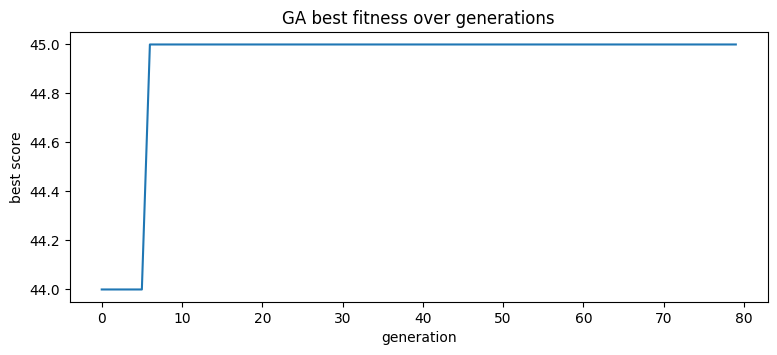

In [12]:
# Minimal GA for bitstring knapsack
# This is a simple Genetic Algorithm (GA) for 0/1 (bitstring) optimisation.
# Each individual is a 0/1 vector of length n_bits:
#   1 = take the item, 0 = do not take the item
# Fitness is given by score_fn (for knapsack, a value score with a penalty if overweight).

def tournament_select(pop: np.ndarray, scores: np.ndarray, k: int = 3) -> np.ndarray:
    # Tournament selection:
    # 1) randomly sample k individuals (without replacement)
    # 2) pick the best among them (highest score)
    # This creates "selection pressure": better solutions are more likely to reproduce,
    # but weaker ones can still win occasionally (maintains diversity).
    idx = rng.choice(len(pop), size=k, replace=False)
    winner = idx[int(np.argmax(scores[idx]))]
    return pop[winner].copy()  # copy so later edits do not modify the population in-place


def single_point_crossover(a: np.ndarray, b: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # Single-point crossover:
    # Choose a cut position, then swap the tails of the two parents to produce two children.
    # This can combine good "building blocks" (useful subsets of items) from each parent.
    if len(a) < 2:
        return a.copy(), b.copy()
    cut = int(rng.integers(1, len(a)))  # cut in [1, n_bits-1]
    c1 = np.concatenate([a[:cut], b[cut:]])
    c2 = np.concatenate([b[:cut], a[cut:]])
    return c1, c2


def mutate_bits(x: np.ndarray, p: float = 0.02) -> np.ndarray:
    # Bit-flip mutation:
    # For each bit independently, flip it with probability p.
    # This introduces new variation, helping the GA escape local optima and avoid premature convergence.
    y = x.copy()
    mask = rng.random(size=len(y)) < p
    y[mask] = 1 - y[mask]
    return y


def genetic_algorithm(
    score_fn: Callable[[np.ndarray], float],
    n_bits: int,
    pop_size: int = 60,
    generations: int = 80,
    crossover_rate: float = 0.9,
    mutation_rate: float = 0.02,
    elitism: int = 2,
) -> Tuple[np.ndarray, float, List[float]]:
    """
    Minimal GA loop:
      - initialise random population
      - repeat:
          evaluate fitness
          keep top elites
          select parents (tournament)
          crossover (with probability crossover_rate)
          mutate children
          form next generation
      - return best individual found and the best-fitness history

    Returns:
      (best_individual, best_score, history_best)
      - history_best[t] is the best fitness seen in generation t
    """
    # Initial population: random 0/1 bitstrings
    pop = rng.integers(0, 2, size=(pop_size, n_bits))
    history_best = []

    for _ in range(generations):
        # Evaluate every individual
        scores = np.array([score_fn(ind) for ind in pop], dtype=float)

        # Sort population by fitness (descending) so pop[0] is best
        order = np.argsort(scores)[::-1]
        pop = pop[order]
        scores = scores[order]

        # Track the best score this generation (useful for plotting progress)
        history_best.append(float(scores[0]))

        new_pop = []

        # Elitism: carry over the top 'elitism' individuals unchanged.
        # This ensures we never lose the best solution found so far due to random crossover/mutation.
        for i in range(elitism):
            new_pop.append(pop[i].copy())

        # Fill the remainder of the new population with children
        while len(new_pop) < pop_size:
            # Select parents (biased toward high fitness)
            p1 = tournament_select(pop, scores, k=3)
            p2 = tournament_select(pop, scores, k=3)

            # Recombine parents to create children (or copy if crossover not applied)
            if rng.random() < crossover_rate:
                c1, c2 = single_point_crossover(p1, p2)
            else:
                c1, c2 = p1.copy(), p2.copy()

            # Mutate children (small random changes)
            c1 = mutate_bits(c1, p=mutation_rate)
            c2 = mutate_bits(c2, p=mutation_rate)

            # Add children into the next generation
            new_pop.append(c1)
            if len(new_pop) < pop_size:
                new_pop.append(c2)

        # Replace the old population with the new one
        pop = np.array(new_pop, dtype=int)

    # Final evaluation: return the best individual from the final population
    scores = np.array([score_fn(ind) for ind in pop], dtype=float)
    best_i = int(np.argmax(scores))
    best = pop[best_i].copy()

    return best, float(scores[best_i]), history_best


# Run the GA on the knapsack objective
best_ga, best_ga_score, hist = genetic_algorithm(
    score_fn=knapsack_score,     # fitness function (higher is better)
    n_bits=len(items),           # one bit per item
    pop_size=60,                 # number of candidate solutions per generation
    generations=80,              # how many generations to evolve
    crossover_rate=0.9,          # how often we recombine parents
    mutation_rate=0.03,          # how often each bit flips
    elitism=2,                   # keep the top 2 solutions each generation
)

# Decode and report the best solution
w, v, names = unpack(best_ga)
print("GA best score:", round(best_ga_score, 2), "| weight:", w, "| value:", v, "| items:", names)

# Plot best fitness per generation to see if the GA is improving
plt.figure(figsize=(9, 3.5))
plt.plot(hist)
plt.title("GA best fitness over generations")
plt.xlabel("generation")
plt.ylabel("best score")
plt.show()


<b>=============================  EXERCISE  =============================</b>


<div class="box task">
  <div class="boxtitle"><span class="badge b-task">✍️</span><b> Exercise 3 (GA parameter tuning)</b></div>
  <p>Run a small parameter sweep and compare outcomes. Use the same score function so the comparison is fair.</p>
  <ol>
    <li>Try <code>mutation_rate ∈ {0.01, 0.03, 0.08}</code>.</li>
    <li>Try <code>pop_size ∈ {30, 60, 120}</code>.</li>
    <li>For each setting, record the final best score and whether the best solution is feasible (<code>weight ≤ capacity</code>).</li>
  </ol>
  <p><b>Prompt:</b> Which setting gives you the best value, and which setting is most stable across runs?</p>
</div>


In [ ]:
# TODO: Exercise 3 solution area (GA parameter tuning)

# Goal: run a small parameter sweep and compare outcomes fairly.
# You will vary:
#   - mutation_rate ∈ {0.01, 0.03, 0.08}
#   - pop_size ∈ {30, 60, 120}
#
# For each setting, record:
#   - final best score
#   - total weight, total value
#   - feasible? (weight <= CAPACITY)
#
# Prompt (write 3–6 sentences at the end):
#   Which setting gives the best value, and which setting is most stable across runs?

# 1) Define the parameter lists (no other values)
# TODO: mutation_rates = [...]
# TODO: pop_sizes = [...]

# 2) Choose how many repeats per setting (recommended >= 3 for stability)
# TODO: n_repeats = ...

# 3) For each (pop_size, mutation_rate) run the GA n_repeats times
# TODO:
# - create a results list to store:
#   (pop_size, mutation_rate, run_id, best_score, weight, value, feasible)
# - loop over pop_size, mutation_rate, and run_id
# - call genetic_algorithm(...) with:
#     score_fn = knapsack_score  (keep fixed)
#     n_bits = len(items)
#     pop_size = pop_size
#     generations = 80           (keep fixed)
#     crossover_rate = 0.9       (keep fixed)
#     mutation_rate = mutation_rate
#     elitism = 2                (keep fixed)
# - unpack(best) to get (w, v, names)
# - feasible = (w <= CAPACITY)
# - append a row into results
# - print one short line per run so you can see outcomes

# TODO

# 4) Summarise results per setting
# TODO:
# - for each (pop_size, mutation_rate):
#     * best score across repeats
#     * mean best score across repeats (stability)
#     * feasible rate across repeats (how often feasible)
# - print a compact summary

# TODO

# 5) Short interpretation (3–6 sentences)
# TODO:
# - Which setting gave the highest value / score?
# - Which setting was most stable (least variation, most consistently feasible)?


<details>
  <summary><b>✅ Show solution (one possible full answer)</b></summary>

```python
# ✅ Exercise 3 solution: GA parameter tuning (mutation_rate x pop_size)

import numpy as np

# 1) Parameter sweep settings
mutation_rates = [0.01, 0.03, 0.08]
pop_sizes = [30, 60, 120]
n_repeats = 5  # repeat each setting to judge stability

results = []  # (pop_size, mutation_rate, run_id, best_score, weight, value, feasible)

# 2) Run the sweep
for pop_size in pop_sizes:
    for mutation_rate in mutation_rates:
        for run_id in range(1, n_repeats + 1):
            best, best_score, _hist = genetic_algorithm(
                score_fn=knapsack_score,   # keep fixed so the comparison is fair
                n_bits=len(items),
                pop_size=pop_size,
                generations=80,            # keep fixed
                crossover_rate=0.9,        # keep fixed
                mutation_rate=mutation_rate,
                elitism=2,                 # keep fixed
            )

            w, v, _names = unpack(best)
            feasible = (w <= CAPACITY)

            results.append((pop_size, mutation_rate, run_id, float(best_score), w, v, feasible))

            print(
                f"pop={pop_size:3d}, mut={mutation_rate:0.2f}, run={run_id}: "
                f"score={best_score:6.2f}, weight={w:2d}, value={v:2d}, feasible={feasible}"
            )

# 3) Summarise per setting
print("\nSummary by (pop_size, mutation_rate)")
print("pop  mut   best_max  mean     std      feasible_rate")

for pop_size in pop_sizes:
    for mutation_rate in mutation_rates:
        rows = [r for r in results if r[0] == pop_size and r[1] == mutation_rate]
        scores = np.array([r[3] for r in rows], dtype=float)
        feas = np.array([r[6] for r in rows], dtype=bool)

        best_max = float(np.max(scores))
        mean = float(np.mean(scores))
        std = float(np.std(scores))
        feas_rate = float(np.mean(feas))

        print(f"{pop_size:3d}  {mutation_rate:0.2f}  {best_max:8.2f}  {mean:7.2f}  {std:7.2f}  {feas_rate:13.2f}")

# 4) Simple interpretation helper (optional)
# - High best_max: best value found at least once
# - Low std + high feasible_rate: stable and reliable


<b>===================================================================</b>


<b>✅ Week 3 Tutorial Complete</b>

<p>
  This concludes <b>Week 3, Local Search and Metaheuristic Optimisation</b>.
  You should now be able to explain the difference between graph search and local search, implement <b>hill climbing</b> (including best-improvement and random-restart variants), and apply local search to a realistic <b>0/1 knapsack</b> selection problem using a penalty-based objective.
  You should also be able to implement a minimal <b>Genetic Algorithm</b> for bitstring optimisation, interpret how selection, crossover, mutation, and elitism influence performance, and run simple parameter sweeps to evaluate trade-offs between solution quality and stability.
</p>
